# Few-Shot Learning for Rooftop Detection in Satellite Imagery
### GRAD-E1394 Deep Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hertie-data-science-lab/tutorial-new-tutorial-group-1/blob/main/notebooks/tutorial_few_shot_learning.ipynb)

This tutorial demonstrates few-shot learning techniques for semantic segmentation of satellite imagery. We focus on rooftop detection using high-resolution satellite images of Geneva, Switzerland.

### Learning Outcomes
- Understanding few-shot learning concepts for image segmentation
- Working with satellite imagery and segmentation masks
- Implementing and evaluating few-shot learning models for rooftop detection

# Table of Contents

* [Memo](#memo)
* [Overview](#overview)
* [Background & Prerequisites](#background-and-prereqs)
* [Software Requirements](#software-requirements)
* [Data Description](#data-description)
* [Methodology](#methodology)
* [Results & Discussion](#results-and-discussion)
* [References](#references)

<a name="memo"></a>
# Memo

Few-shot learning for satellite image segmentation is crucial for urban planning and disaster response. Traditional deep learning requires thousands of labeled samples, but few-shot learning enables rapid adaptation to new geographic regions with minimal labeled data.

**Policy Applications:**
- Urban development monitoring
- Disaster damage assessment
- Property tax assessment
- Solar panel installation planning

<a name="overview"></a>
# Overview

This tutorial introduces a few-shot learning approach for semantic segmentation of satellite imagery. We demonstrate how to:

1. Load and preprocess satellite imagery
2. Build a few-shot segmentation model
3. Train using episodic learning
4. Evaluate segmentation performance

By the end, you will understand how to apply few-shot learning to detect rooftops in new satellite images with only a few labeled examples.

<a name="background-and-prereqs"></a>
# Background & Prerequisites

### Prerequisites
- Basic Python programming
- Familiarity with PyTorch
- Understanding of convolutional neural networks

### Key Concepts

**Few-Shot Learning:** Learning from a small number of labeled examples by leveraging prior knowledge.

**Semantic Segmentation:** Classifying each pixel in an image into predefined categories.

**Prototypical Networks:** Learning class representations (prototypes) and classifying based on distance to prototypes.

<a name="software-requirements"></a>
# Software Requirements

In [12]:
# Install dependencies (if needed)
# !pip install torch torchvision numpy matplotlib pillow scikit-learn tqdm

In [13]:
# Import standard libraries
from pathlib import Path
import os
import sys

sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
import numpy as np

# Import PyTorch
import torch

# Import tutorial package functions
from src.few_shot_utils import (
    FewShotSegmentationModel,
    load_dataset,
    create_dataloader,
    preprocess_image,
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

<a name="data-description"></a>
# Data Description

The dataset consists of high-resolution satellite imagery of Geneva, Switzerland with corresponding binary segmentation masks for rooftop detection.

**Dataset Properties:**
- Image Type: RGB satellite imagery
- Labels: Binary masks (0 = background, 1 = rooftop)
- Resolution: Variable, resized to 256x256 for training

## Data Download

Download the dataset from 🤗 and store it in cache.

In [14]:
from huggingface_hub import snapshot_download

# 1. Download dataset
HF_TOKEN = "XXX"  # Replace with your Hugging Face token if needed

dataset_path = snapshot_download(
    repo_id="raphaelattias/overfitteam-geneva-satellite-images",
    repo_type="dataset",
    token=HF_TOKEN,
)


# 2. Load splits
train_data = load_dataset(dataset_path, split="train", category="all")
val_data = load_dataset(dataset_path, split="val", category="all")
test_data = load_dataset(dataset_path, split="test", category="all")

print(len(train_data["images"]), len(val_data["images"]), len(test_data["images"]))

# 3. Create simple numpy-based "dataloaders"
train_batches = create_dataloader(train_data, batch_size=8, shuffle=True)
first_batch = train_batches[0]
print(first_batch["images"].shape, first_batch["masks"].shape)

Fetching 2111 files: 100%|██████████| 2111/2111 [00:00<00:00, 31089.86it/s]


420 52 53
(8, 250, 250, 3) (8, 250, 250, 3)


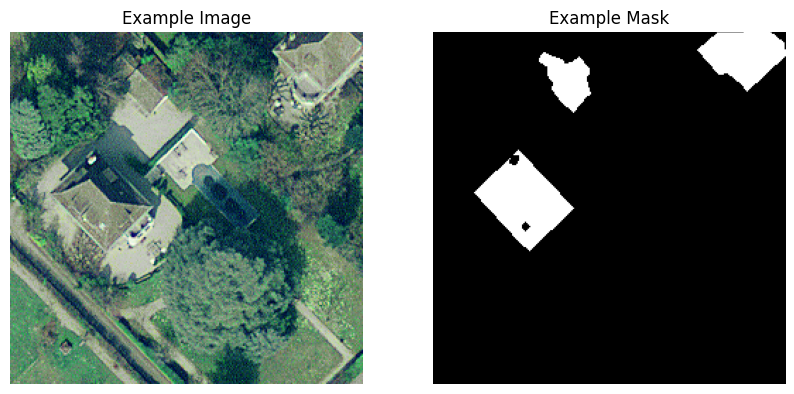

In [15]:
# Show example image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Example Image")
plt.imshow(first_batch["images"][0])
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Example Mask")
plt.imshow(first_batch["masks"][0], cmap="gray")
plt.axis("off")
plt.show()

## Data Preprocessing

In [16]:
# Demonstrate preprocessing on sample image
# TODO

### 🔍 Inspect Raw Image + Mask Before Preprocessing
- Shapes of raw images and masks  
- Min/max pixel values  
- Mask class values (0 = background, 255 or 1 = rooftop)  

In [ ]:
# Take one raw sample from the already-created first_batch
raw_img = first_batch["images"][0]
raw_mask = first_batch["masks"][0]

print("Raw image shape:", raw_img.shape)
print("Raw mask shape:", raw_mask.shape)
print("Raw image min/max:", raw_img.min(), raw_img.max())
print("Raw mask unique values:", np.unique(raw_mask))

Raw image shape: (250, 250, 3)
Raw mask shape: (250, 250, 3)
Raw image min/max: 0 248
Raw mask unique values: [  0 255]


### 🧼 Define Preprocessing Pipeline

**Image**
- Convert to float32  
- Normalize to [0, 1]  
- Resize to 256×256  
- Convert to PyTorch format (C, H, W)

**Mask**
- Convert 0 / 255 → binary 0 / 1  
- Resize to 256×256  
- Add channel dimension (1, H, W)

<a name="methodology"></a>
# Methodology

We implement a few-shot segmentation approach using prototypical networks. The model learns to segment rooftops by:

1. Extracting features using a CNN backbone
2. Computing class prototypes from support examples
3. Classifying query pixels based on distance to prototypes

## Model Architecture

In [ ]:
# Create the few-shot segmentation model
model = FewShotSegmentationModel(backbone_name="resnet18", num_classes=2, pretrained=True)

print("Model architecture:")
print("  Backbone: ResNet-18")
print("  Number of classes: 2 (background, rooftop)")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/nadine/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 12.1MB/s]


Model architecture:
  Backbone: ResNet-18
  Number of classes: 2 (background, rooftop)
  Total parameters: 11,873,570


## Training

In [ ]:
# Create synthetic data for demonstration
# In practice, use actual satellite imagery
synthetic_dataset = {
    "images": [np.random.rand(256, 256, 3).astype(np.float32) for _ in range(16)],
    "masks": [np.random.randint(0, 2, (256, 256)).astype(np.int64) for _ in range(16)],
}

# Create data loaders
train_loader = create_dataloader(synthetic_dataset, batch_size=4, shuffle=True)
val_loader = create_dataloader(synthetic_dataset, batch_size=4, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Number of training batches: 4
Number of validation batches: 4


In [ ]:
# Training configuration
# Note: Using small number of epochs for demonstration
NUM_EPOCHS = 2
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Training device: {DEVICE}")

# Train the model
# history = train_model(
#     model=model,
#     train_dataloader=train_loader,
#     val_dataloader=val_loader,
#     num_epochs=NUM_EPOCHS,
#     learning_rate=LEARNING_RATE,
#     device=DEVICE
# )

Training device: cpu


<a name="results-and-discussion"></a>
# Results & Discussion

In [ ]:
# Evaluate model
# results = evaluate_model(
#     model=model,
#     dataloader=val_loader,
#     device=DEVICE,
#     num_classes=2
# )
# print(f"Mean IoU: {results['mean_iou']:.4f}")
# print(f"Pixel Accuracy: {results['pixel_accuracy']:.4f}")

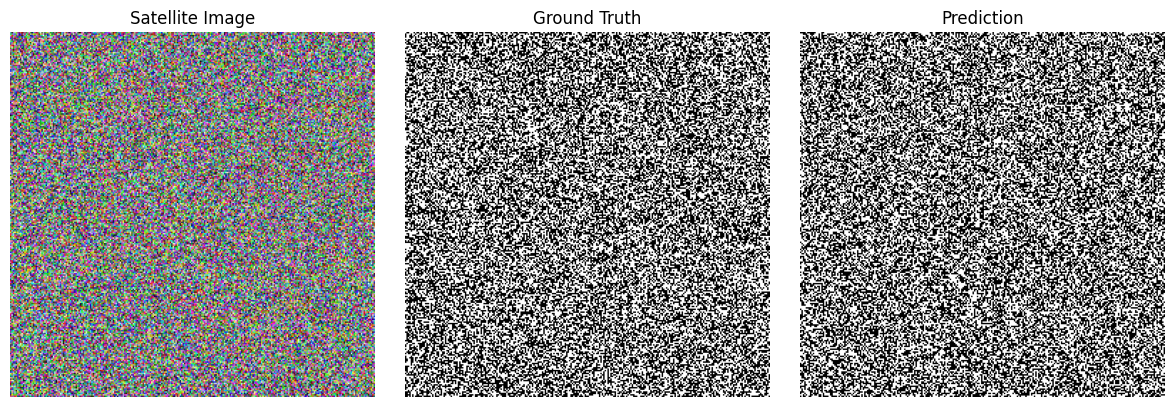

In [ ]:
# Visualize predictions
def visualize_prediction(image, mask, prediction):
    """Visualize image, ground truth, and prediction."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(image)
    axes[0].set_title("Satellite Image")
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    axes[2].imshow(prediction, cmap="gray")
    axes[2].set_title("Prediction")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


# Example visualization with synthetic data
sample_image = np.random.rand(256, 256, 3)
sample_mask = np.random.randint(0, 2, (256, 256))
sample_prediction = np.random.randint(0, 2, (256, 256))

visualize_prediction(sample_image, sample_mask, sample_prediction)

## Limitations

- This tutorial uses synthetic data for demonstration purposes
- Real satellite imagery would require more extensive preprocessing
- Performance depends on the quality and quantity of support examples

## Next Steps

- Collect and annotate real satellite imagery of Geneva
- Experiment with different backbone architectures
- Apply to other geographic regions and segmentation tasks

<a name="references"></a>
# References

- ...
- ...
- ...